## PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

## Tutorial 6: Incorporation of Temporal Uncertainty in Gaussian Process (15-20 minutess)

When analyzing paleo environmental data, e.g., relative sea-level (RSL) records, it is important to consider the presence of uncertainties in both the reconstruction of RSL (vertical axis) and the chronology (horizontal axis) of the data. While it is relatively straightforward to incorporate output data uncertainty using variance-weighted Gaussian Process (GP) regression (i.e., adding vertical variance into the diagonal of covariance matrix), incorporating chronological uncertainties in GP regression is more challenging.

In this tutorial, we will demonstrate two commonly used methods for incorporating temporal uncertainty in paleo sea-level research. Specifically, we will cover:

**&#10148; 1.** Noisy-input Gaussian Process 

**&#10148; 2.** Errors-in-variable Gaussian Process 

**&#10148; 3.** Performance Comparison 

To demonstrate, let's start with loading the module and generating some synthetic noisy data from a sine wave:

In [2]:
#load modules
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import sys
sys.path.append('../..')
import PSTHM 
import seaborn as sns

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20,
       'family':'Arial'}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

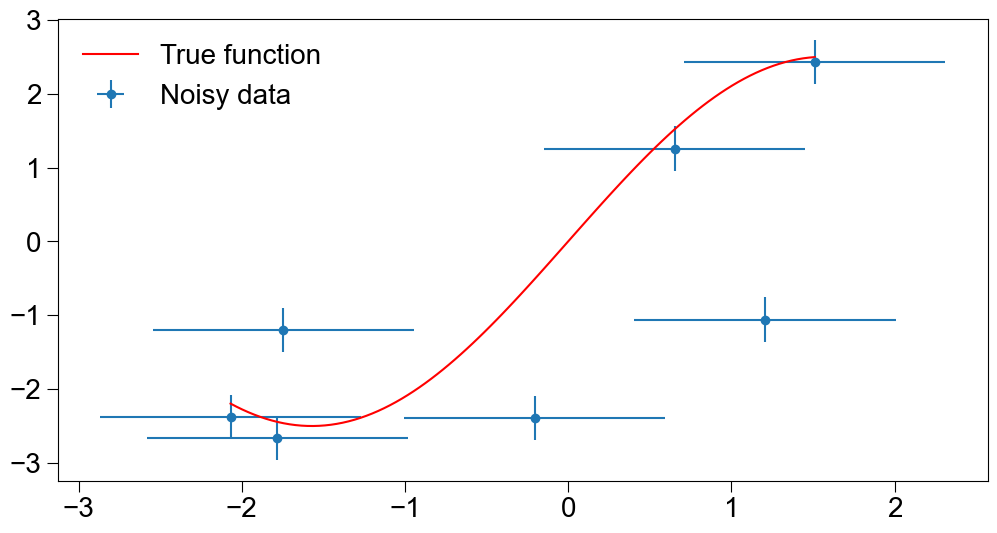

In [3]:
np.random.seed(130)
x = torch.linspace(-3,3,100).double()[np.sort(np.random.randint(0,100,7))]
def f(x):
    return 2.5*torch.sin(x)*torch.ones(len(x)).double()*torch.ones(len(x)).double()**2
y = f(x)

x_noise = 0.8
y_noise =0.3
x_noisy = x+np.random.normal(0,x_noise,len(x))
y_noisy = y+np.random.normal(0,y_noise,len(y))

x_full = torch.linspace(x_noisy.min(),x_noisy.max(),100).double()

plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0',label='Noisy data')
plt.plot(x_full,f(x_full),color='r',label='True function')

plt.legend();

You can clearly see that our data is very noisy and provide really limited information on the right side of the function. Let's start with normal GP only considering the vertical uncertainty. You should be failry familiar with the code below, which is the same code we used for past several tutorials:

In [8]:
# Normal GP without considering x error
pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = PSTHM.kernels.RBF(input_dim=1,variance=torch.tensor(1.),lengthscale=torch.tensor(1.))
RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(0.5), torch.tensor(30.)))
RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.1), torch.tensor(30.)))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.model.GPRegression_V(x_noisy,y_noisy, RBF_kernel,noise=torch.ones(len(x))*y_noise**2,jitter=1e-5)

# #Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.opti.SVI_optm(gpr,num_iteration=1000)

print('Length Scale: ',track_list['lengthscale'].iloc[-1],'Variance: ',track_list['variance'].iloc[-1])

#cal mean and variance of GP
GP_mean, GP_var = gpr(x_full, full_cov=True)
GP_sd = torch.diag(GP_var).sqrt()  # standard deviation at each input point x


  0%|          | 0/1000 [00:00<?, ?it/s]

Length Scale:  1.7789904012206272 Variance:  3.994682483862343


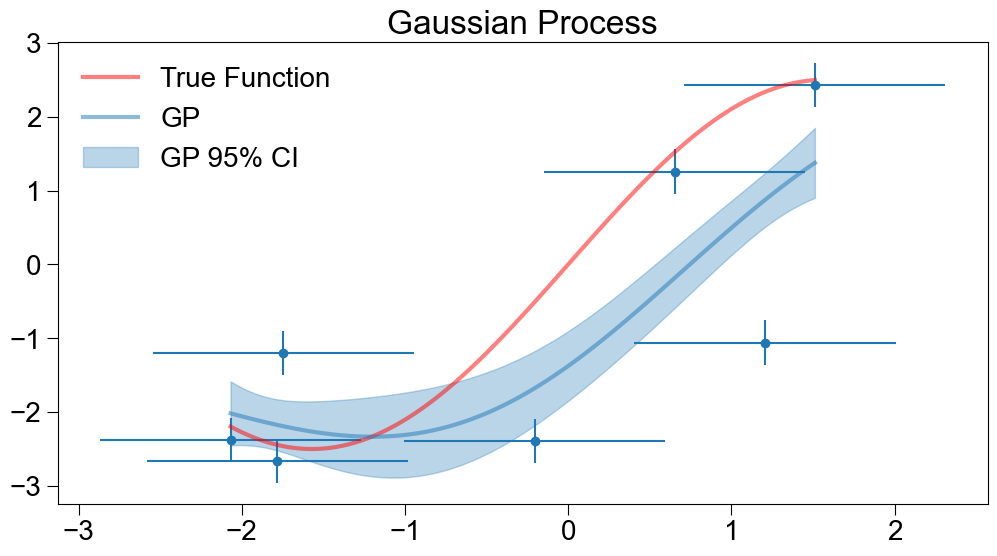

In [9]:
plt.title('Gaussian Process')
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')

plt.plot(x_full,f(x_full),color='r',label='True Function',linewidth=3,alpha=0.5)
plt.plot(x_full,GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,GP_mean.detach().numpy()-2*GP_sd.detach().numpy(),GP_mean.detach().numpy()+2*GP_sd.detach().numpy(),alpha=0.3,color='C0',label='GP 95% CI')
plt.legend();

Due to the significant uncertainties present in both the x and y axes of the data, the 95% credible interval (CI) obtained from normal Gaussian Process (GP) regression fails to accurately capture the true underlying function within the range between 0 and 2.5.

### 1. Noisy-Input Gaussian Process

Now, let's explore the noisy-input GP (NIGP) method. The NIGP method employs a first-order Taylor series approximation, which involves a linear expansion around each input point. This approximation enables the translation of errors in the temporal domain into equivalent errors in the relative sea-level (RSL) domain. Consequently, temporal uncertainty is transformed into RSL uncertainty, which is proportional to the squared gradient of the GP posterior mean.

Let's write it down. Recall in GP background tutorial that, the observation $y$ can be noisy:
$$
y_{i} = f(t_{i},x_{i}) + \epsilon_{i}
$$

where indicates vertical uncertainty for each data point. Additionally, we consider input variable $t$ to be noisy as well here:
$$
\overline{t}_{i} = t_{i} + \delta{i}
$$
where $\overline{t}_{i}$ is the central point estimate of the input variable (e.g., calibrated age from geochronology), $t_{i}$ is the true input variable (e.g., true age), which is unknown and unobserved, and $\delta_{i}$ is the uncertainty for input variable (e.g., chronological uncertainty). For GP, it is default to assume both $\epsilon$ and $\delta$ to be normally distributed. 

For GP framework, vertical uncertainty can be easily incorporated by changing $K^{-1}$ (details in section 3 of tutorial 4) to:
$$
\hat{K}^{-1} = (K+\sigma_{\epsilon}^2 I)^{-1}
$$
where $I$ is an identity matrix and $\sigma_{\epsilon}$ indicates one-sigma observational uncertainty for each data point. To implement NIGP, we need to estimate the gradient of GP posterior mean relative to input variable: $\partial f = \frac{\partial f}{\partial t}$. It can then be used to transform temporal uncertainty into RSL uncertainty, and therefore, the covariance matrix is:
$$
\hat{K}^{-1}_{NIGP} = (K+\sigma_{epsilon}^2 I +\sigma_{\delta}^2\partial f^{2}I )^{-1}
$$
where $\sigma_{\delta}$ is one-sigma uncertainty for input variable. 

To implement the NIGP method, we use an iterative method, which calculate $\frac{\partial f}{\partial t}$ for every iteration of optimization. To do this in PaleoSTeHM framework is very easy, you just change the optimization function from `SVI_optm` to `SVI_NI_optm`, which requires an extra input of horizontal uncertainty. 

In [6]:

pyro.clear_param_store()

#generate a RBF kernel 
NI_RBF_kernel = PSTHM.kernels.RBF(input_dim=1,variance=torch.tensor(1.),lengthscale=torch.tensor(1.))
NI_RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(0.1), torch.tensor(30.)))
NI_RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.1), torch.tensor(30.)))

#generate a GP gression model conditioned on RSL data
NI_gpr = PSTHM.model.GPRegression_V(x_noisy,y_noisy, RBF_kernel,noise=torch.ones(len(x))*y_noise**2,jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
NI_gpr,track_list = PSTHM.opti.SVI_NI_optm(NI_gpr,torch.tensor(x_noise),num_iteration=1000)
print('Length Scale: ',track_list['lengthscale'].iloc[-1],'Variance: ',track_list['variance'].iloc[-1])

#cal mean and variance of GP
NIGP_mean, NIGP_var = NI_gpr(x_full, full_cov=True)
NIGP_sd = torch.diag(NIGP_var).sqrt()  # standard deviation at each input point x

  0%|          | 0/1000 [00:00<?, ?it/s]

Length Scale:  2.389514370701731 Variance:  3.8110091107567765


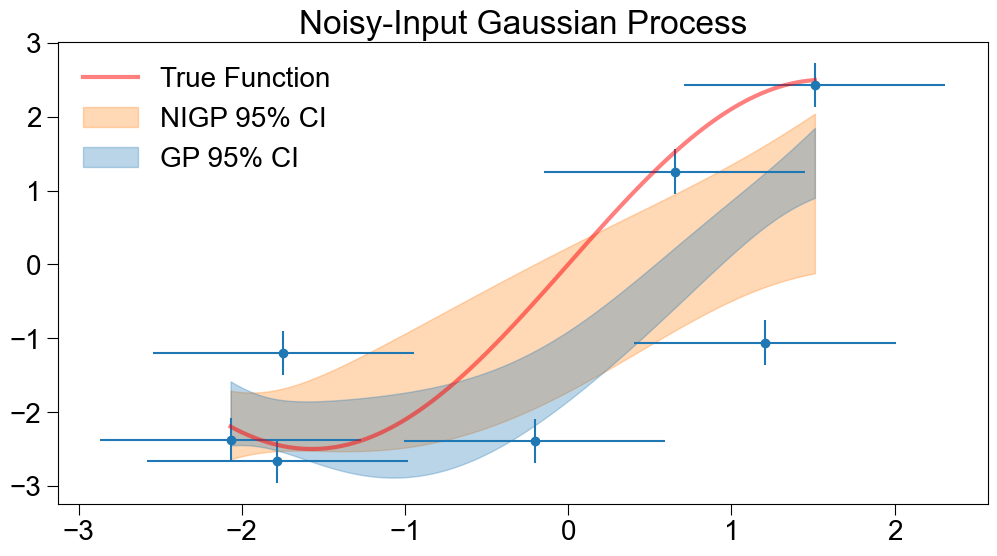

In [7]:
plt.title('Noisy-Input Gaussian Process')

plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')

plt.plot(x_full,f(x_full),color='r',label='True Function',linewidth=3,alpha=0.5)
# plt.plot(x_full,GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)

# plt.plot(x_full,NIGP_mean.detach().numpy(),color='C1',label='NIGP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,NIGP_mean.detach().numpy()-2*NIGP_sd.detach().numpy(),NIGP_mean.detach().numpy()+2*NIGP_sd.detach().numpy(),alpha=0.3,color='C1',label='NIGP 95% CI')
plt.fill_between(x_full,GP_mean.detach().numpy()-2*GP_sd.detach().numpy(),GP_mean.detach().numpy()+2*GP_sd.detach().numpy(),alpha=0.3,color='C0',label='GP 95% CI')
plt.legend();

Upon incorporating information about chronological errors, the 95% credible interval (CI) obtained through the noisy-input Gaussian Process (NI-GP) method exhibits an improvement, demonstrating a more reasonable behavior when dealing with the noisy data. Notably, the 95% CI successfully captures the true underlying function across a larger range. It should be noted that, given the same hyperparameters, considering chronological uncertainty using NI-GP will always results in larger 95% CI. 

### 2. Errors-In-Variable Gaussian Process

Another approach to address temporal uncertainty is by directly sampling temporal uncertainty using the errors-in-variable (EIV) framework through the utilization of the Markov Chain Monte Carlo (MCMC) algorithm, which enables a Fully Bayesian Analysis. This can be done by calculating covariance matrix with input uncertainty.

It is important to note that specifying the prior distribution is crucial in the Fully Bayesian Analysis as it directly impacts the prediction results. To implement EIV-GP in PaleoSTeHM, we change the GP model from `GPRegression_V` to `GPRegression_EIV` and fill this new model to MCMC sampler as before.

In [8]:
# EIV-GP method
from pyro.infer.mcmc import MCMC, NUTS

pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = PSTHM.kernels.RBF(input_dim=1)
RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(0.1), torch.tensor(30.)))
RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.1), torch.tensor(30.)))

#generate a GP gression model conditioned on RSL data
EIV_gpr = PSTHM.model.GPRegression_EIV(x_noisy, y_noisy, x_noise = x_noise**2,kernel=RBF_kernel,noise=torch.tensor(y_noise**2),jitter=1e-5)

#use NUTS mcmc to sample the posterior distribution of hyperparameters
mcmc = PSTHM.opti.NUTS_mcmc(EIV_gpr,num_samples=2000,warmup_steps=200)


Sample: 100%|██████████| 2200/2200 [00:32, 67.50it/s, step size=3.12e-01, acc. prob=0.810]


In [9]:
#predict the mean and variance of GP
post_x = mcmc.get_samples()['xerr'].detach().numpy()+x_noisy[None,:].detach().numpy()
post_y = np.random.normal(y_noisy,y_noise,[2000,len(y)])

full_bayes_y = np.zeros([2000,len(x_full)])
full_bayes_std = np.zeros([2000,len(x_full)])

for i in range(2000):
    EIV_gpr.X = torch.tensor(post_x[i])
    EIV_gpr.y = torch.tensor(post_y[i])
    EIV_gpr.kernel.lengthscale = mcmc.get_samples()['kernel.lengthscale'][i]
    EIV_gpr.kernel.variance = mcmc.get_samples()['kernel.variance'][i]
    test_mean,test_cov = EIV_gpr(x_full)
    full_bayes_y[i] = test_mean.detach().numpy()
    full_bayes_std[i] = test_cov.sqrt().detach().numpy()
EIVGP_mean = np.mean(full_bayes_y,axis=0)
EIVGP_sd = np.std(full_bayes_y,axis=0)

Text(0.5, 1.0, 'Length scale: 3.246 +/- 1.953 ')

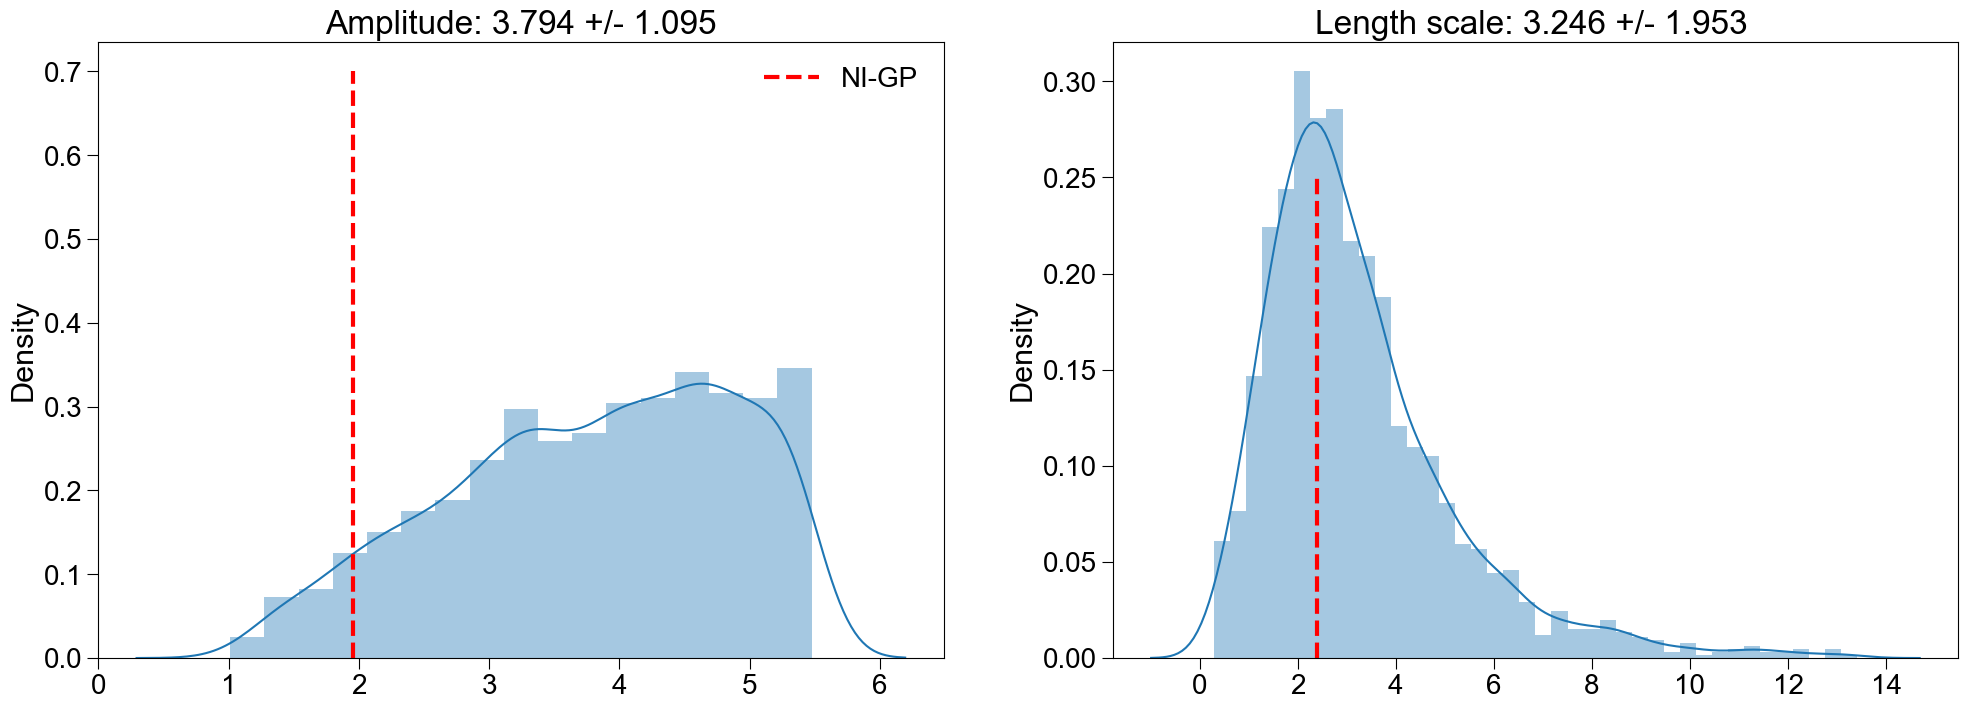

In [10]:
mcmc_variance =mcmc.get_samples()['kernel.variance']
mcmc_lengthscale = mcmc.get_samples()['kernel.lengthscale']

plt.figure(figsize=(24,8))
plt.subplot(121)
sns.distplot(mcmc_variance**0.5)
plt.vlines(NI_gpr.kernel.variance.item()**0.5,0,0.7,color='r',linestyle='--',label='NI-GP',linewidth=3)
plt.title('Amplitude: {:5.3f} +/- {:5.3f}'.format(torch.mean(mcmc_variance**0.5),
                                            torch.std(mcmc_variance**0.5)))
plt.legend()
plt.subplot(122)
sns.distplot(mcmc_lengthscale)
plt.vlines(NI_gpr.kernel.lengthscale.item(),0,0.25,color='r',linestyle='--',label='NI-GP',linewidth=3)
plt.title('Length scale: {:5.3f} +/- {:5.3f} '.format(torch.mean(mcmc_lengthscale),
                                                           torch.std(mcmc_lengthscale)))

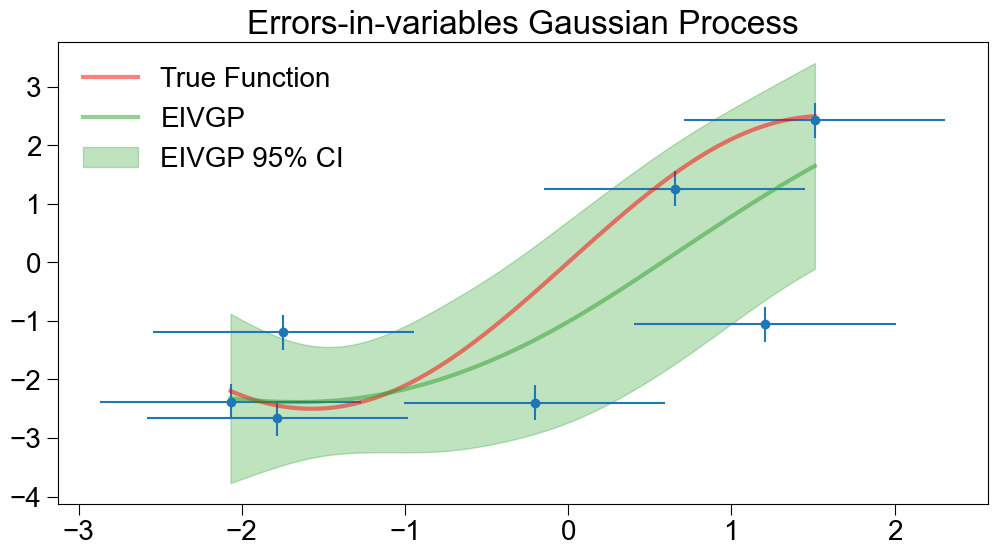

In [11]:


plt.title('Errors-in-variables Gaussian Process')
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')
plt.plot(x_full,f(x_full),color='r',label='True Function',linewidth=3,alpha=0.5)
plt.plot(x_full,EIVGP_mean,color='C2',label='EIVGP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,EIVGP_mean-2*EIVGP_sd,EIVGP_mean+2*EIVGP_sd,alpha=0.3,color='C2',label='EIVGP 95% CI')
plt.legend();



It is quite evident that the 95% CI obtained through the Errors-in-Variable Gaussian Process (EIV-GP) method exhibits a more structured behavior compared to the Noisy-Input GP (NI-GP) method. This improved structure is a result of directly sampling the x errors using the MCMC algorithm within the EIV-GP framework. Like NI-GP, the 95% CI derived from the EIV-GP method captures the true underlying function over a good area.

### 3. Performance Comparison 

Now, let's compare and visualize the outcomes of the three different methods by plotting them together for a comprehensive evaluation. We also calculate the percentage of whether their 68/95% confidence interval can cover the true function as an extra evaluation metric. 

GP 68/95% coverage percentage:  0.18/ 0.39
NIGP 68/95% coverage percentage:  0.28/ 0.62
EIVGP 68/95% coverage percentage:  0.52/ 1.00


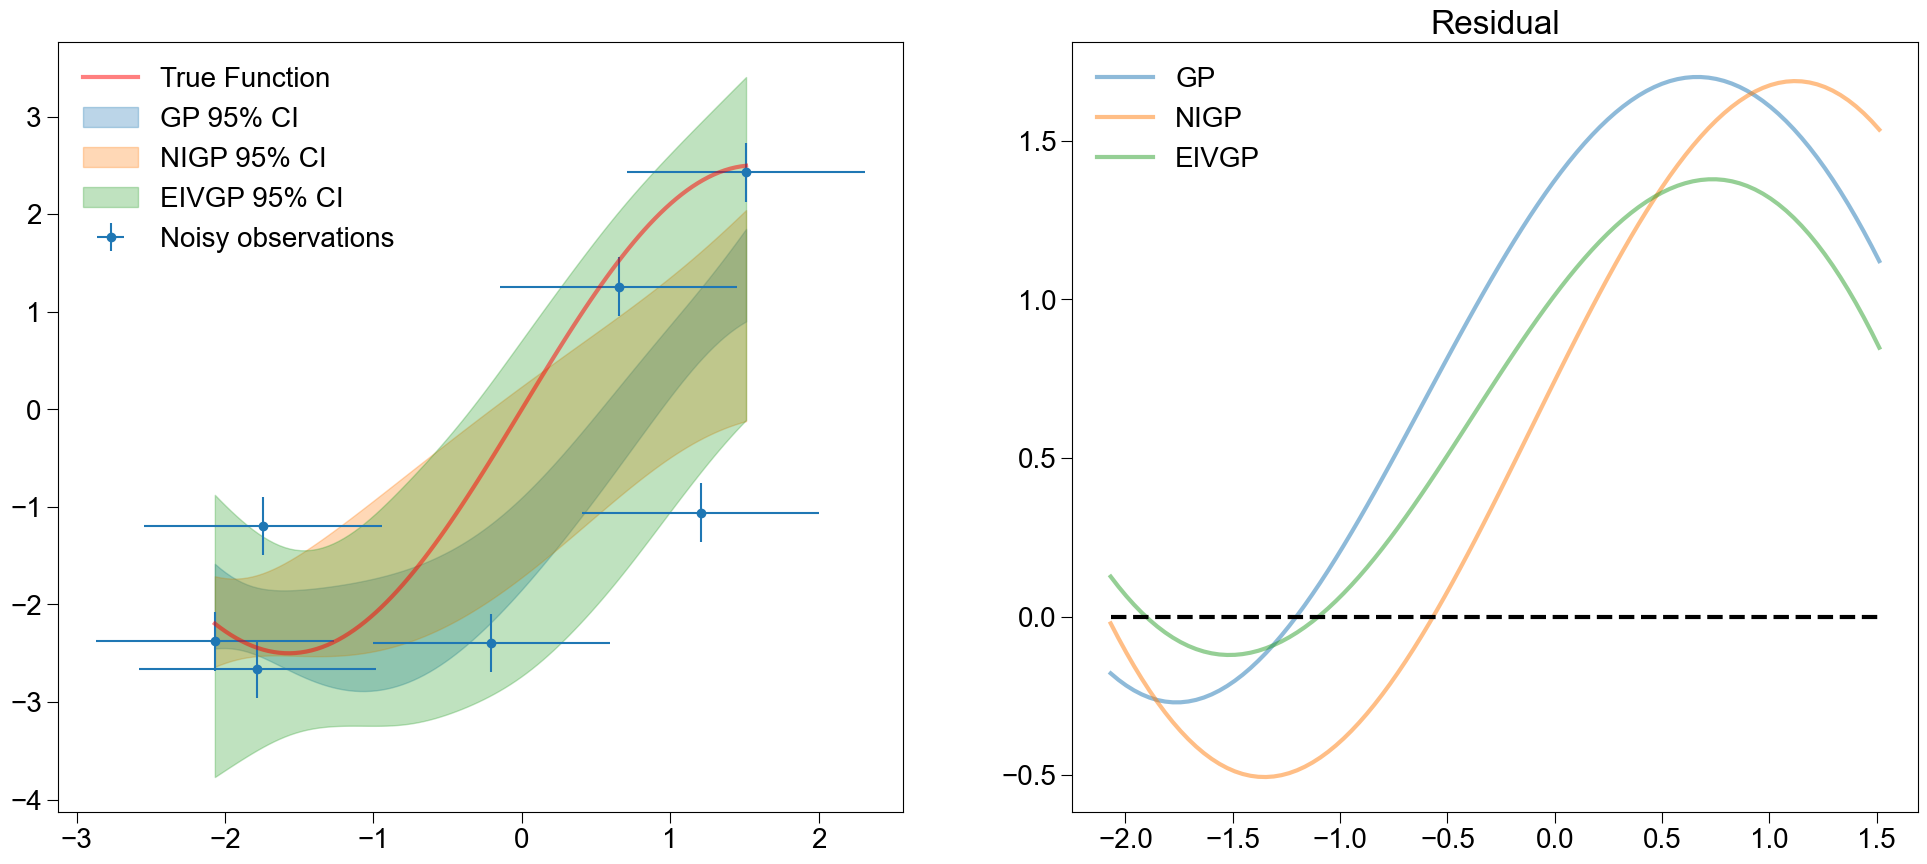

In [12]:
print('GP 68/95% coverage percentage: {0:5.2f}/{1:5.2f}'.format(np.mean(np.abs(GP_mean.detach().numpy()-f(x_full).detach().numpy())<GP_sd.detach().numpy()),
      np.mean(np.abs(GP_mean.detach().numpy()-f(x_full).detach().numpy())<2*GP_sd.detach().numpy())))
print('NIGP 68/95% coverage percentage: {0:5.2f}/{1:5.2f}'.format(np.mean(np.abs(NIGP_mean.detach().numpy()-f(x_full).detach().numpy())<NIGP_sd.detach().numpy()),
      np.mean(np.abs(NIGP_mean.detach().numpy()-f(x_full).detach().numpy())<2*NIGP_sd.detach().numpy())))
print('EIVGP 68/95% coverage percentage: {0:5.2f}/{1:5.2f}'.format(np.mean(np.abs(EIVGP_mean-f(x_full).detach().numpy())<EIVGP_sd),
      np.mean(np.abs(EIVGP_mean-f(x_full).detach().numpy())<2*EIVGP_sd)))

plt.figure(figsize=(24,10))
plt.subplot(121)
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0',label='Noisy observations')

plt.plot(x_full,f(x_full),color='r',label='True Function',linewidth=3,alpha=0.5)

plt.fill_between(x_full,GP_mean.detach().numpy()-2*GP_sd.detach().numpy(),GP_mean.detach().numpy()+2*GP_sd.detach().numpy(),alpha=0.3,color='C0',label='GP 95% CI')
plt.fill_between(x_full,NIGP_mean.detach().numpy()-2*NIGP_sd.detach().numpy(),NIGP_mean.detach().numpy()+2*NIGP_sd.detach().numpy(),alpha=0.3,color='C1',label='NIGP 95% CI')
plt.fill_between(x_full,EIVGP_mean-2*EIVGP_sd,EIVGP_mean+2*EIVGP_sd,alpha=0.3,color='C2',label='EIVGP 95% CI')

plt.legend()

plt.subplot(122)
plt.plot(x_full,f(x_full)-GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
plt.plot(x_full,f(x_full)-NIGP_mean.detach().numpy(),color='C1',label='NIGP',linewidth=3,alpha=0.5)
plt.plot(x_full,f(x_full)-EIVGP_mean,color='C2',label='EIVGP',linewidth=3,alpha=0.5)
plt.hlines(0,x_full.min(),x_full.max(),linewidth=3,linestyles='--',color='k')
plt.title('Residual')
plt.legend();

It seems like EIV-GP is doing a great job here, followed by NI-GP and GP. This is largely because EIV-GP is able to sample the posterior distribution of age uncertainty of each data, therefore, EIV-GP is trying to find the `TRUE` age distribution. Meanwhile, GP and EIV-GP do not modify the noisy prior age distributions although NI-GP is trying to improve the prediction accuracy based on nosiy prior distributions. 

To make it more clear, we can compare the noisy prior distributions, posterior distributions with `True age` respectively.


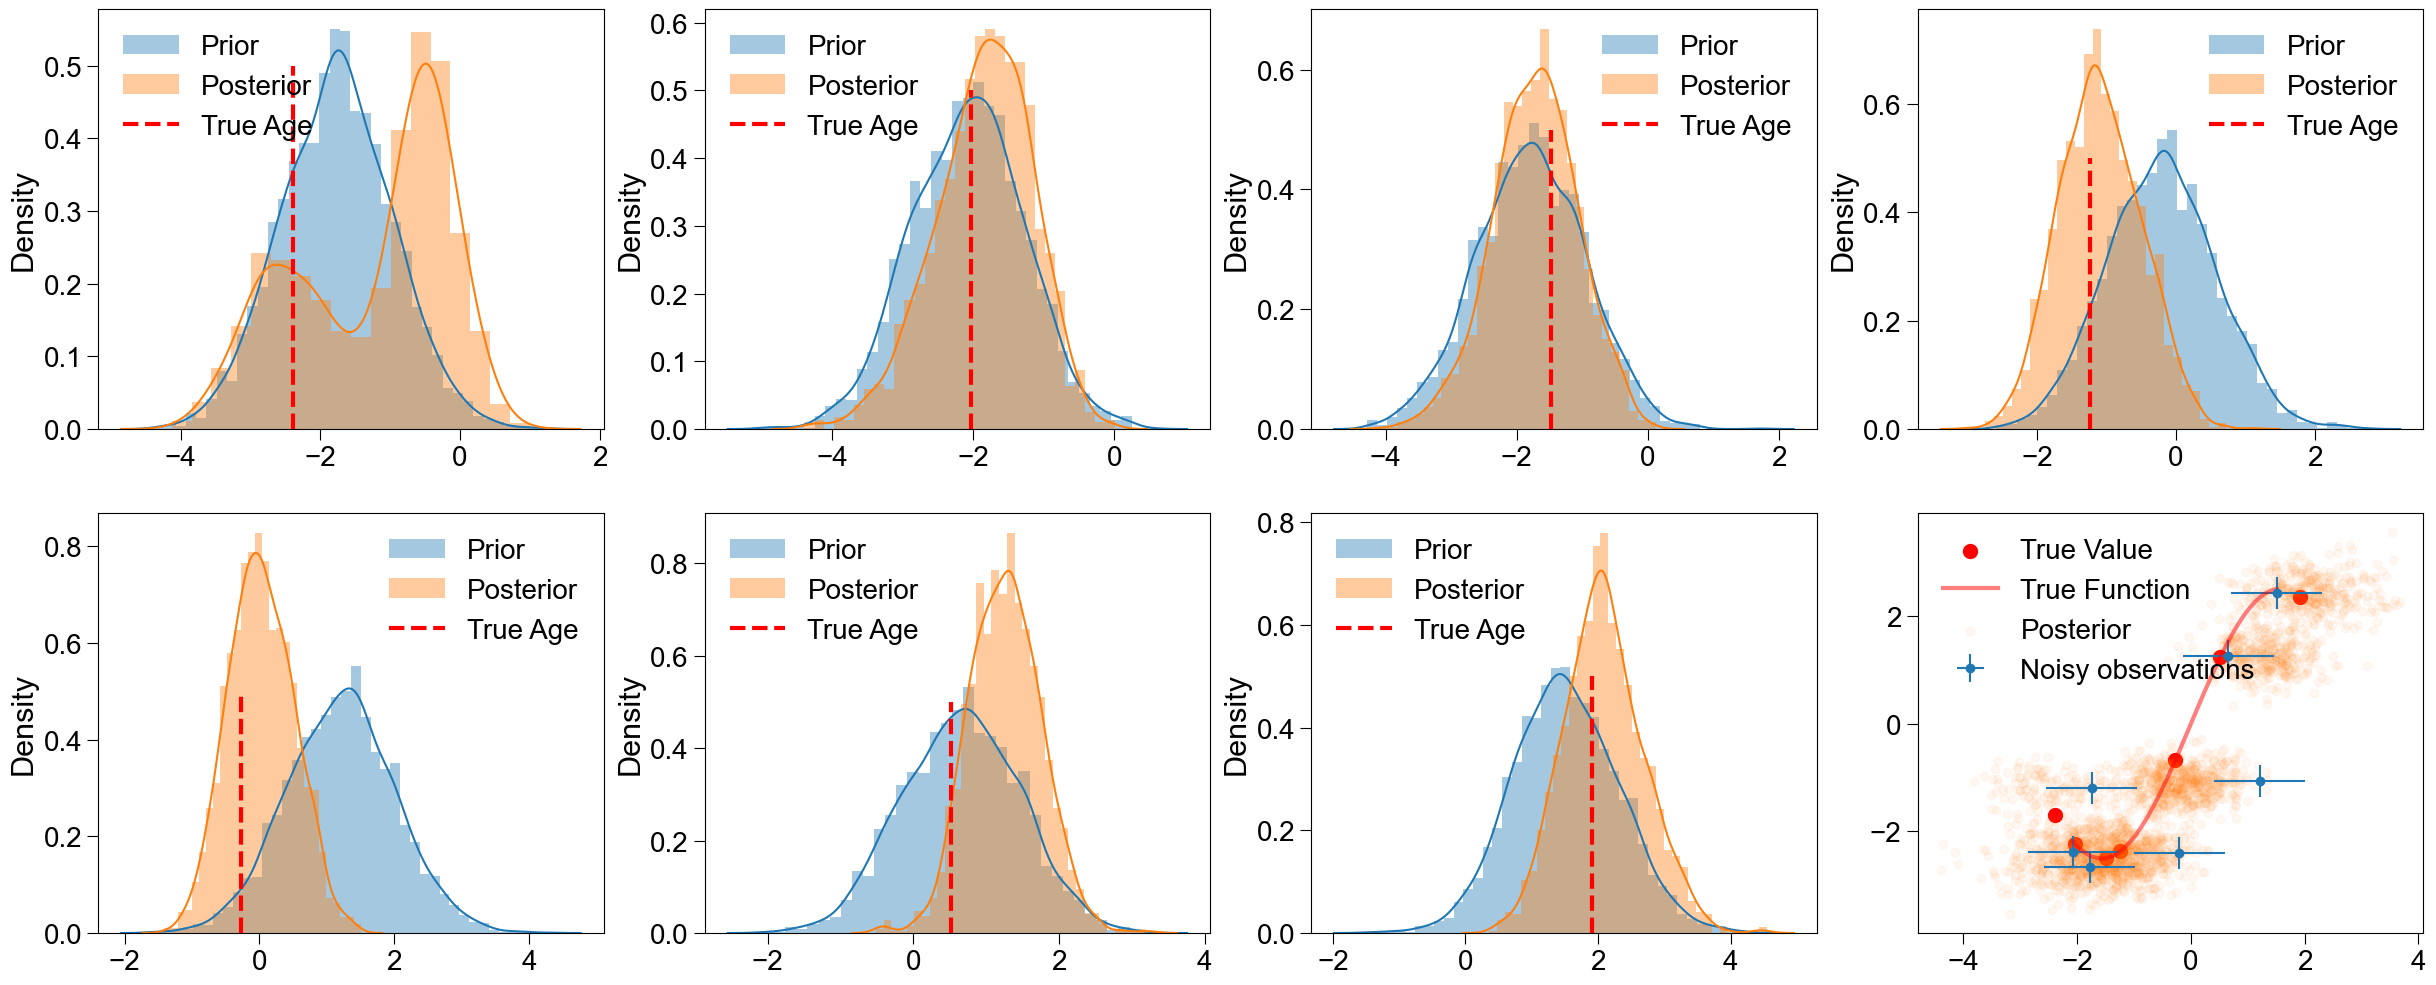

In [13]:
plt.figure(figsize=(30,12))
for i in range(7):
    plt.subplot(2,4,i+1)
    sns.distplot(np.random.normal(x_noisy[i],x_noise,3000),label='Prior')
    sns.distplot(post_x[:,i],label='Posterior')
    plt.vlines(x[i],0,0.5,color='r',linestyle='--',label='True Age',linewidth=3)
    plt.legend()
plt.subplot(2,4,8)
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0',label='Noisy observations')
plt.scatter(x,y,color='r',label='True Value',s=100)
plt.plot(x_full,f(x_full),color='r',label='True Function',linewidth=3,alpha=0.5)

for i in range(0,2000,5):
    if i ==0:
        plt.scatter(post_x[i],post_y[i],color='C1',alpha=0.05,label='Posterior')
    else:
        plt.scatter(post_x[i],post_y[i],color='C1',alpha=0.05)
plt.legend();

We can find that the posterior distributions inferred by EIV-GP fit better to the `True` age.


### Test with alternative data

Let's try to generate some new data from a different sine wave function and see how do they perform. 

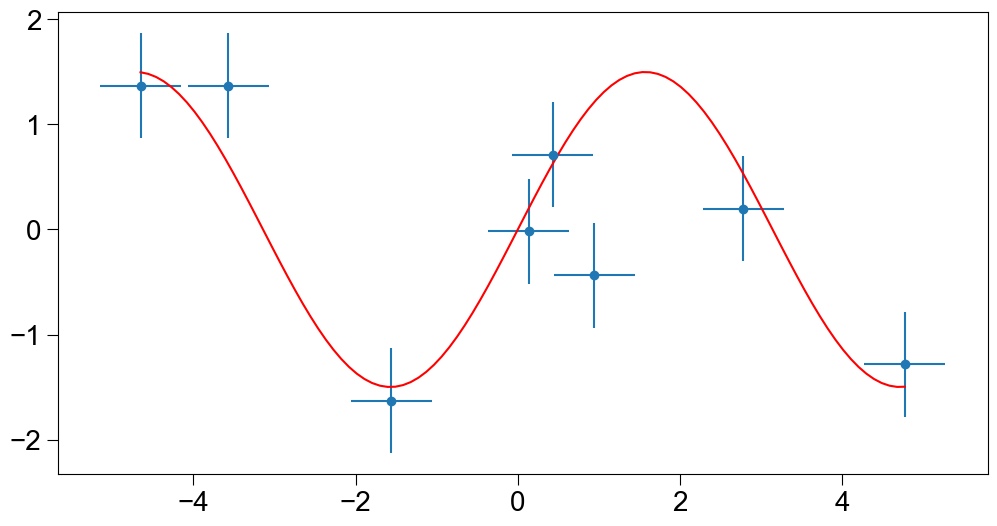

In [14]:
np.random.seed(1234)
x = torch.linspace(-6,6,100).double()[np.sort(np.random.randint(0,100,8))]
def f(x):
    return  1.5*torch.sin(x)
y = f(x)

x_noise = 0.5
y_noise =0.5
x_noisy = x+np.random.normal(0,x_noise,len(x))
y_noisy = y+np.random.normal(0,y_noise,len(y))
x_full = torch.linspace(x_noisy.min(),x_noisy.max(),100).double()

plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')
plt.plot(x_full,f(x_full),color='r');

You can see that the observational data still looks quite confusing, let's see how different GPs recovery the true function!

In [16]:
# Normal GP without considering x error
pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = PSTHM.kernels.RBF(input_dim=1,variance=torch.tensor(1.),lengthscale=torch.tensor(1.))
RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.), torch.tensor(10.)))
RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(1.), torch.tensor(100.)))

#generate a GP gression model conditioned on RSL data
gpr =  PSTHM.model.GPRegression_V(x_noisy, y_noisy, RBF_kernel,noise=torch.ones(len(y))*y_noise**2,jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.opti.SVI_optm(gpr,num_iteration=1000)

print('Length Scale: ',track_list['lengthscale'].iloc[-1],'Variance: ',track_list['variance'].iloc[-1])

#cal mean and variance of GP
GP_mean, GP_var = gpr(x_full, full_cov=True)
GP_sd = torch.diag(GP_var).sqrt()  # standard deviation at each input point x


  0%|          | 0/1000 [00:00<?, ?it/s]

Length Scale:  1.0010398585329894 Variance:  1.0208229555039583


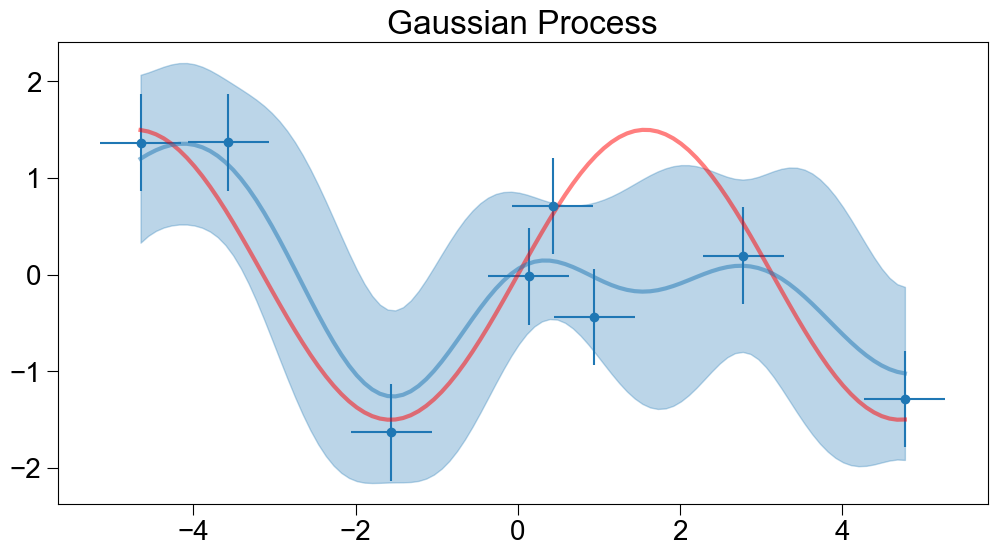

In [17]:
plt.title('Gaussian Process')
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')

plt.plot(x_full,f(x_full),color='r',label='Ground Truth',linewidth=3,alpha=0.5)
plt.plot(x_full,GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,GP_mean.detach().numpy()-2*GP_sd.detach().numpy(),GP_mean.detach().numpy()+2*GP_sd.detach().numpy(),alpha=0.3,color='C0',label='GP 95% CI');

In [18]:

pyro.clear_param_store()

#generate a RBF kernel 
NI_RBF_kernel = PSTHM.kernels.RBF(input_dim=1,variance=torch.tensor(1.),lengthscale=torch.tensor(1.))
NI_RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.), torch.tensor(10.)))
NI_RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(1.), torch.tensor(100.)))
#generate a GP gression model conditioned on RSL data
NI_gpr =  PSTHM.model.GPRegression_V(x_noisy, y_noisy, NI_RBF_kernel,noise=torch.ones(len(y))*y_noise**2,jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
NI_gpr,track_list = PSTHM.opti.SVI_NI_optm(NI_gpr,torch.tensor(x_noise),num_iteration=1000)
print('Length Scale: ',track_list['lengthscale'].iloc[-1],'Variance: ',track_list['variance'].iloc[-1])

#cal mean and variance of GP
NIGP_mean, NIGP_var = NI_gpr(x_full, full_cov=True)
NIGP_sd = torch.diag(NIGP_var).sqrt()  # standard deviation at each input point x

  0%|          | 0/1000 [00:00<?, ?it/s]

Length Scale:  1.002520759961745 Variance:  1.0120815670957863


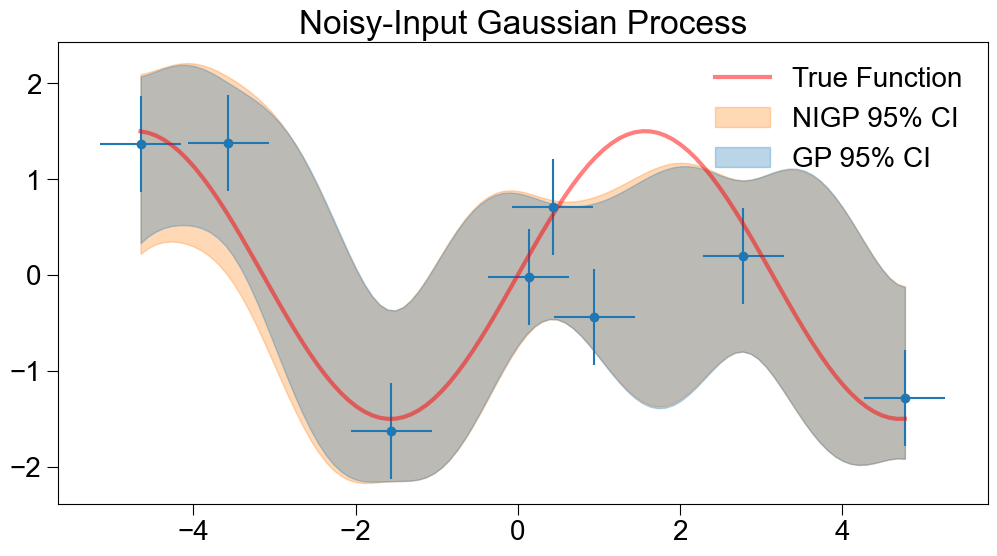

In [19]:
plt.title('Noisy-Input Gaussian Process')

plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')

plt.plot(x_full,f(x_full),color='r',label='True Function',linewidth=3,alpha=0.5)
# plt.plot(x_full,GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
# plt.plot(x_full,NIGP_mean.detach().numpy(),color='C1',label='NIGP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,NIGP_mean.detach().numpy()-2*NIGP_sd.detach().numpy(),NIGP_mean.detach().numpy()+2*NIGP_sd.detach().numpy(),alpha=0.3,color='C1',label='NIGP 95% CI')
plt.fill_between(x_full,GP_mean.detach().numpy()-2*GP_sd.detach().numpy(),GP_mean.detach().numpy()+2*GP_sd.detach().numpy(),alpha=0.3,color='C0',label='GP 95% CI')
plt.legend();

In [20]:
# EIV-GP method

pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = PSTHM.kernels.RBF(input_dim=1)
RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.1), torch.tensor(100.)))
RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(0.1), torch.tensor(10.)))

#generate a GP gression model conditioned on RSL data
EIV_gpr = PSTHM.model.GPRegression_EIV(x_noisy, y_noisy,x_noise= x_noise**2,kernel = RBF_kernel,noise=torch.tensor(y_noise**2),jitter=1e-5)

#use NUTS mcmc to sample the posterior distribution of hyperparameters
#if this is too low, slightly decrease the target_accept_prob and restart again!
mcmc = PSTHM.opti.NUTS_mcmc(EIV_gpr,num_samples=2000,warmup_steps=200)



Sample: 100%|██████████| 2200/2200 [00:30, 71.21it/s, step size=3.33e-01, acc. prob=0.888]


Text(0.5, 1.0, 'Length scale: 2.099 +/- 1.814 ')

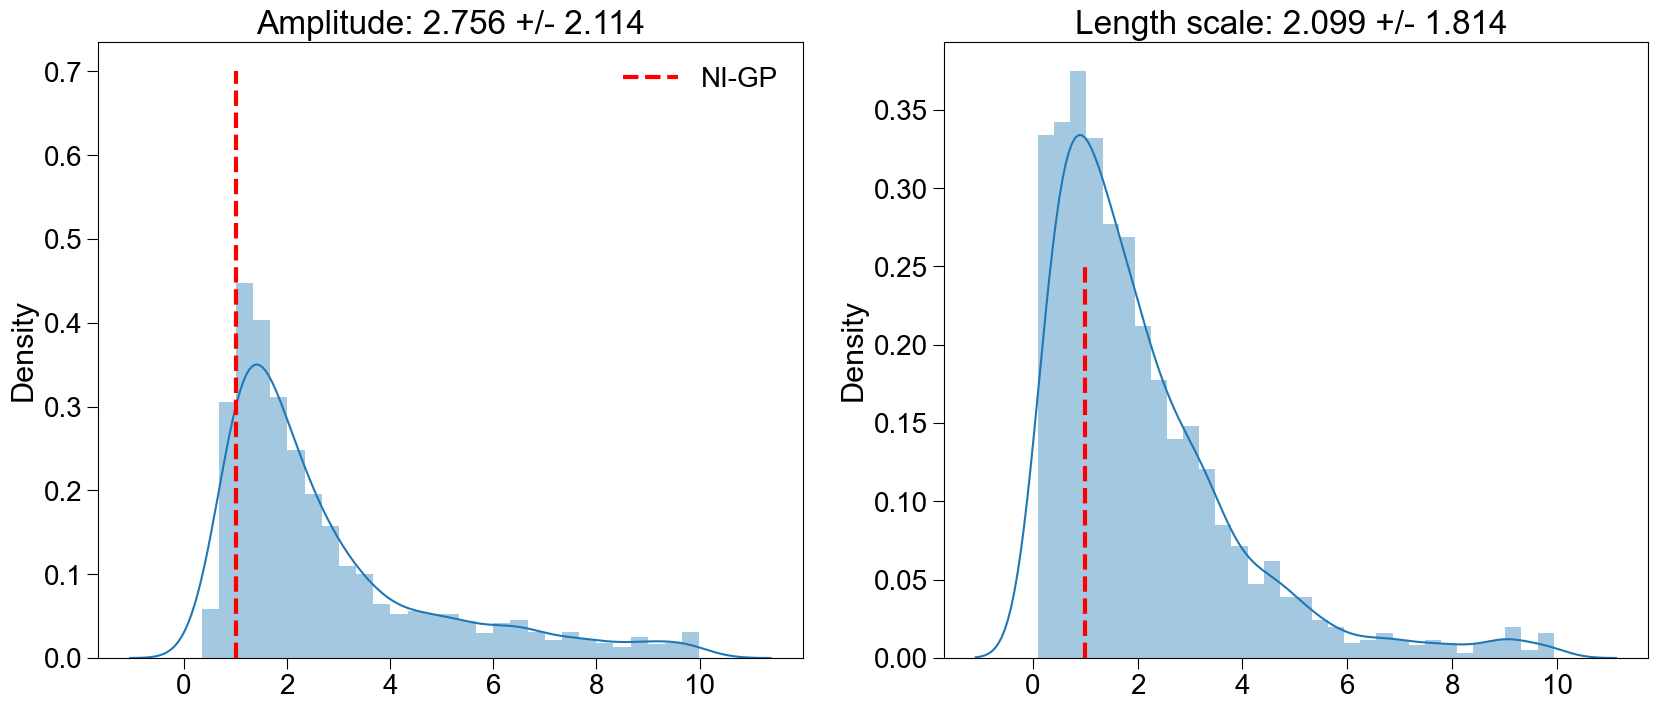

In [22]:
mcmc_variance =mcmc.get_samples()['kernel.variance']
mcmc_lengthscale = mcmc.get_samples()['kernel.lengthscale']

plt.figure(figsize=(20,8))
plt.subplot(121)
sns.distplot(mcmc_variance**0.5)
plt.vlines(NI_gpr.kernel.variance.item()**0.5,0,0.7,color='r',linestyle='--',label='NI-GP',linewidth=3)
plt.title('Amplitude: {:5.3f} +/- {:5.3f}'.format(torch.mean(mcmc_variance**0.5),
                                            torch.std(mcmc_variance**0.5)))
plt.legend()
plt.subplot(122)
sns.distplot(mcmc_lengthscale)
plt.vlines(NI_gpr.kernel.lengthscale.item(),0,0.25,color='r',linestyle='--',label='NI-GP',linewidth=3)
plt.title('Length scale: {:5.3f} +/- {:5.3f} '.format(torch.mean(mcmc_lengthscale),
                                                           torch.std(mcmc_lengthscale)))


In [23]:
#get posterior predictive distributions
post_x = mcmc.get_samples()['xerr'].detach().numpy()+x_noisy[None,:].detach().numpy()
post_y = np.random.normal(y_noisy,y_noise,[2000,len(y)])

full_bayes_y = np.zeros([2000,len(x_full)])
full_bayes_std = np.zeros([2000,len(x_full)])

for i in range(2000):
    gpr.X = torch.tensor(post_x[i])
    gpr.y = torch.tensor(post_y[i])
    gpr.kernel.lengthscale = mcmc.get_samples()['kernel.lengthscale'][i]
    gpr.kernel.variance = mcmc.get_samples()['kernel.variance'][i]
    test_mean,test_cov = gpr(x_full)
    full_bayes_y[i] = test_mean.detach().numpy()
    full_bayes_std[i] = test_cov.sqrt().detach().numpy()
EIVGP_mean = np.mean(full_bayes_y,axis=0)
EIVGP_sd = np.std(full_bayes_y,axis=0)

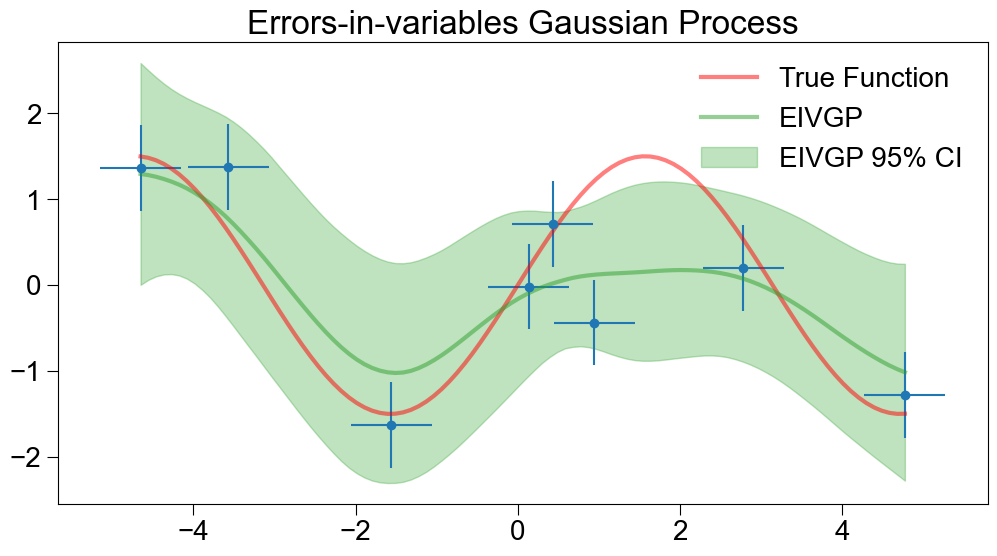

In [24]:

plt.title('Errors-in-variables Gaussian Process')
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')
plt.plot(x_full,f(x_full),color='r',label='True Function',linewidth=3,alpha=0.5)
plt.plot(x_full,EIVGP_mean,color='C2',label='EIVGP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,EIVGP_mean-2*EIVGP_sd,EIVGP_mean+2*EIVGP_sd,alpha=0.3,color='C2',label='EIVGP 95% CI')
plt.legend();

GP 68/95% coverage percentage:  0.60  0.81
NIGP 68/95% coverage percentage:  0.71  0.82
EIVGP 68/95% coverage percentage:  0.70  0.83


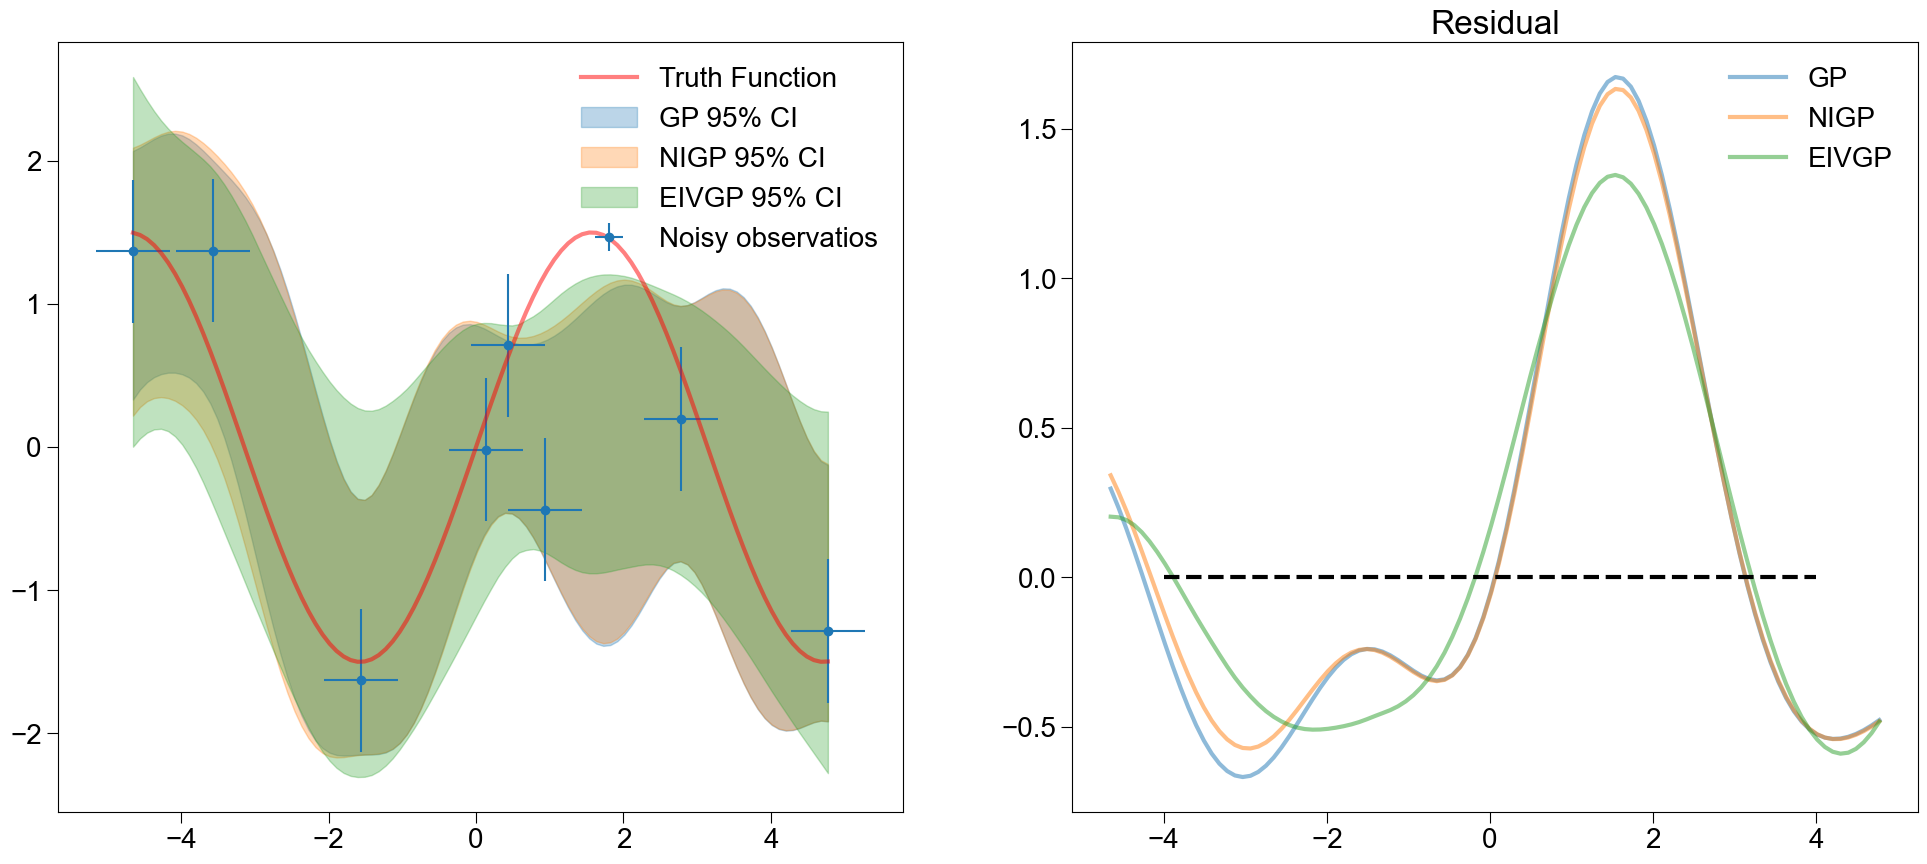

In [25]:

print('GP 68/95% coverage percentage: {0:5.2f} {1:5.2f}'.format(np.mean(np.abs(GP_mean.detach().numpy()-f(x_full).detach().numpy())<GP_sd.detach().numpy()),
      np.mean(np.abs(GP_mean.detach().numpy()-f(x_full).detach().numpy())<2*GP_sd.detach().numpy())))
print('NIGP 68/95% coverage percentage: {0:5.2f} {1:5.2f}'.format(np.mean(np.abs(NIGP_mean.detach().numpy()-f(x_full).detach().numpy())<NIGP_sd.detach().numpy()),
      np.mean(np.abs(NIGP_mean.detach().numpy()-f(x_full).detach().numpy())<2*NIGP_sd.detach().numpy())))
print('EIVGP 68/95% coverage percentage: {0:5.2f} {1:5.2f}'.format(np.mean(np.abs(EIVGP_mean-f(x_full).detach().numpy())<EIVGP_sd),
      np.mean(np.abs(EIVGP_mean-f(x_full).detach().numpy())<2*EIVGP_sd)))

plt.figure(figsize=(24,10))
plt.subplot(121)
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0',label='Noisy observatios')

plt.plot(x_full,f(x_full),color='r',label='Truth Function',linewidth=3,alpha=0.5)
# plt.plot(x_full,GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
# plt.plot(x_full,NIGP_mean.detach().numpy(),color='C1',label='NIGP',linewidth=3,alpha=0.5)
# plt.plot(x_full,EIVGP_mean,color='C2',label='EIVGP',linewidth=3,alpha=0.5)

plt.fill_between(x_full,GP_mean.detach().numpy()-2*GP_sd.detach().numpy(),GP_mean.detach().numpy()+2*GP_sd.detach().numpy(),alpha=0.3,color='C0',label='GP 95% CI')
plt.fill_between(x_full,NIGP_mean.detach().numpy()-2*NIGP_sd.detach().numpy(),NIGP_mean.detach().numpy()+2*NIGP_sd.detach().numpy(),alpha=0.3,color='C1',label='NIGP 95% CI')
plt.fill_between(x_full,EIVGP_mean-2*EIVGP_sd,EIVGP_mean+2*EIVGP_sd,alpha=0.3,color='C2',label='EIVGP 95% CI');

plt.legend()

plt.subplot(122)
plt.plot(x_full,f(x_full)-GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
plt.plot(x_full,f(x_full)-NIGP_mean.detach().numpy(),color='C1',label='NIGP',linewidth=3,alpha=0.5)
plt.plot(x_full,f(x_full)-EIVGP_mean,color='C2',label='EIVGP',linewidth=3,alpha=0.5)
plt.hlines(0,-4,4,linewidth=3,linestyles='--',color='k')
plt.title('Residual')
plt.legend();

Even observations are still very noisy, three GPs did a good job in recoverying the truth signal! Both EIV-GP and NI-GP methods seem to show the great performance here. But for more complicated problem, EIV-GP may be very computationally expensive, in that case NI-GP can be a good substitute. 

We have now covered most of commonly-used concept for temporal modelling with GP, so in the next tutorial, we will use what we have learnt to perform temporal GP modelling in New Jersey and Northern North Carolina and compared them with published results. 

Thanks for going through this tutorial, we are actively developing PaleoSTeHM now, so your feedback will be truely valueable to us. You can fill this [survey](https://forms.gle/W1DMPQY8KyAgoT9r6) to let us know what do you think about this tutorial, which will shape the future direction of PaleoSTeHM.